In [30]:
#| code-summary: Load packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [31]:
#| echo: false
pd.options.display.notebook_repr_html = False

In [33]:
flights = pd.read_csv('data/flights.csv')
airlines = pd.read_csv('data/airlines.csv')
airports = pd.read_csv('data/airports.csv')
planes = pd.read_csv('data/planes.csv')
weather = pd.read_csv('data/weather.csv')

### 1.

In [34]:
# 1. Add the location of the origin and destination (i.e. the lat and lon in airports) to flights.

In [35]:
airport_location = airports[['faa', 'lat', 'lon']]
airport_location

      faa   lat    lon
0     04G 41.13 -80.62
1     06A 32.46 -85.68
2     06C 41.99 -88.10
...   ...   ...    ...
1455  ZWI 39.74 -75.55
1456  ZWU 38.90 -77.01
1457  ZYP 40.75 -73.99

[1458 rows x 3 columns]

In [36]:
# Origin의 위치 정보 추가
flights = flights.merge(airport_location, left_on='origin', right_on='faa').drop(columns="faa")  # faa 컬럼은 중복되어 불필요하므로 삭제
flights.head(3)

   year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0  2013      1    1    517.00             515       2.00    830.00   
1  2013      1    1    554.00             558      -4.00    740.00   
2  2013      1    1    555.00             600      -5.00    913.00   

   sched_arr_time  arr_delay carrier  flight tailnum origin dest  air_time  \
0             819      11.00      UA    1545  N14228    EWR  IAH    227.00   
1             728      12.00      UA    1696  N39463    EWR  ORD    150.00   
2             854      19.00      B6     507  N516JB    EWR  FLL    158.00   

   distance  hour  minute   lat    lon  
0      1400     5      15 40.69 -74.17  
1       719     5      58 40.69 -74.17  
2      1065     6       0 40.69 -74.17  

In [37]:
# dest의 경우 airports 테이블에 없는 값이 존재
flights[~flights.dest.isin(airport_location.faa)].head(3)

    year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
21  2013      1    1    701.00             700       1.00   1123.00   
57  2013      1    1    913.00             918      -5.00   1346.00   
60  2013      1    1    926.00             929      -3.00   1404.00   

    sched_arr_time  arr_delay carrier  flight tailnum origin dest  air_time  \
21            1154     -31.00      UA    1203  N77296    EWR  SJU    188.00   
57            1416     -30.00      UA    1519  N24715    EWR  STT    189.00   
60            1421     -17.00      B6     215  N775JB    EWR  SJU    191.00   

    distance  hour  minute   lat    lon  
21      1608     7       0 40.69 -74.17  
57      1634     9      18 40.69 -74.17  
60      1608     9      29 40.69 -74.17  

In [38]:
# flights 테이블을 유지하기 위해, how="left" 필요
# suffixes 옵션 사용하면 편리

flights = flights.merge(
    airport_location,
    left_on="dest",
    right_on="faa",
    how="left",
    suffixes=("_origin", "_dest"),  # lat, lon이 다시 추가되어 중복되므로 suffixes 옵션 사용
).drop("faa", axis=1)

In [39]:
flights.head(3)

   year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0  2013      1    1    517.00             515       2.00    830.00   
1  2013      1    1    554.00             558      -4.00    740.00   
2  2013      1    1    555.00             600      -5.00    913.00   

   sched_arr_time  arr_delay carrier  ...  origin dest air_time distance  \
0             819      11.00      UA  ...     EWR  IAH   227.00     1400   
1             728      12.00      UA  ...     EWR  ORD   150.00      719   
2             854      19.00      B6  ...     EWR  FLL   158.00     1065   

   hour  minute  lat_origin  lon_origin  lat_dest  lon_dest  
0     5      15       40.69      -74.17     29.98    -95.34  
1     5      58       40.69      -74.17     41.98    -87.90  
2     6       0       40.69      -74.17     26.07    -80.15  

[3 rows x 22 columns]

### 2.

In [40]:
# 2. Is there a relationship between the age of a plane and its delays?

plane_age = (
    planes[["tailnum", "year"]]
    .merge(flights, on="tailnum", how="right", suffixes=("_plane", ""))  # 두 테이블의 year의 의미가 다름
    .assign(age=lambda x: x.year - x.year_plane)
)

In [41]:
plane_age.head(3)

  tailnum  year_plane  year  month  day  dep_time  sched_dep_time  dep_delay  \
0  N14228     1999.00  2013      1    1    517.00             515       2.00   
1  N39463     2012.00  2013      1    1    554.00             558      -4.00   
2  N516JB     2000.00  2013      1    1    555.00             600      -5.00   

   arr_time  sched_arr_time  ...  dest air_time  distance hour minute  \
0    830.00             819  ...   IAH   227.00      1400    5     15   
1    740.00             728  ...   ORD   150.00       719    5     58   
2    913.00             854  ...   FLL   158.00      1065    6      0   

   lat_origin  lon_origin  lat_dest  lon_dest   age  
0       40.69      -74.17     29.98    -95.34 14.00  
1       40.69      -74.17     41.98    -87.90  1.00  
2       40.69      -74.17     26.07    -80.15 13.00  

[3 rows x 24 columns]

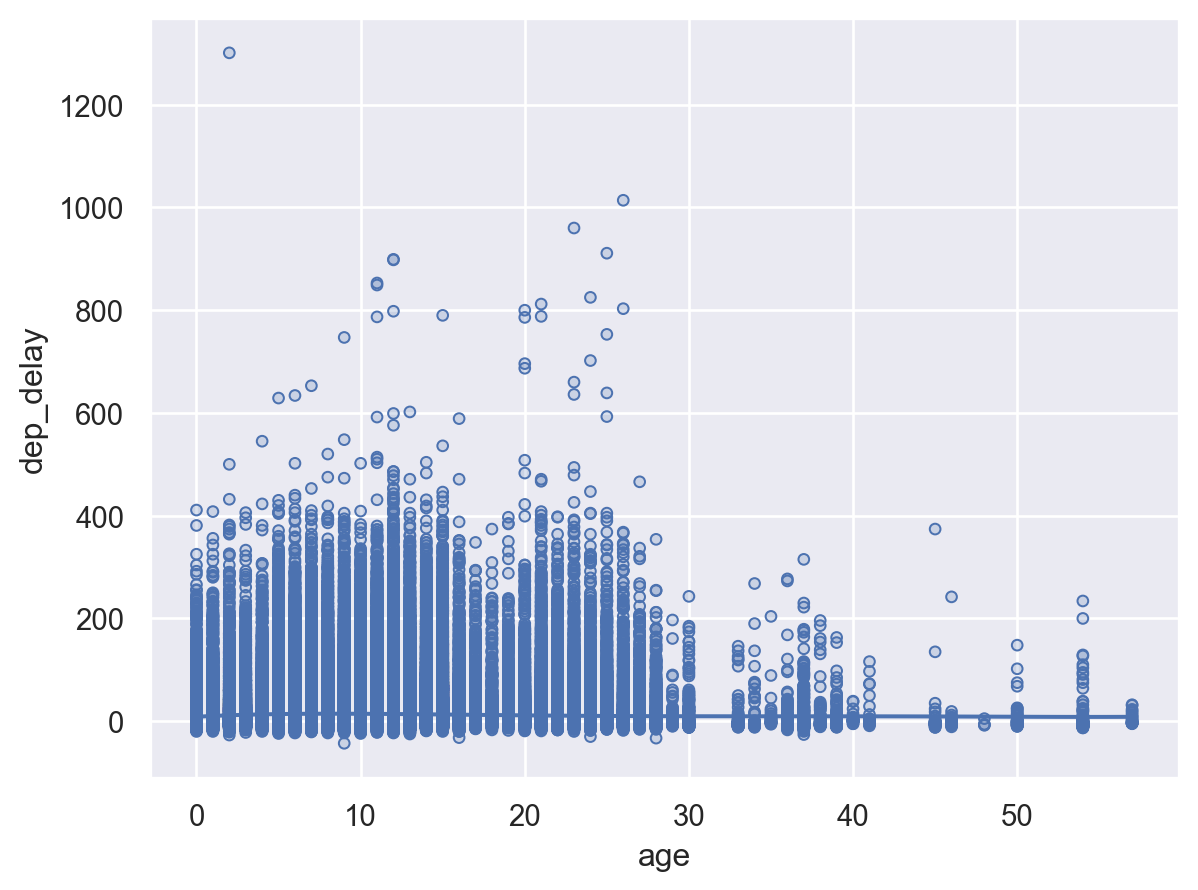

In [42]:
# 항공기의 연식(age)와 출발 지연과의 관계
(
    so.Plot(plane_age, x='age', y='dep_delay')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
)

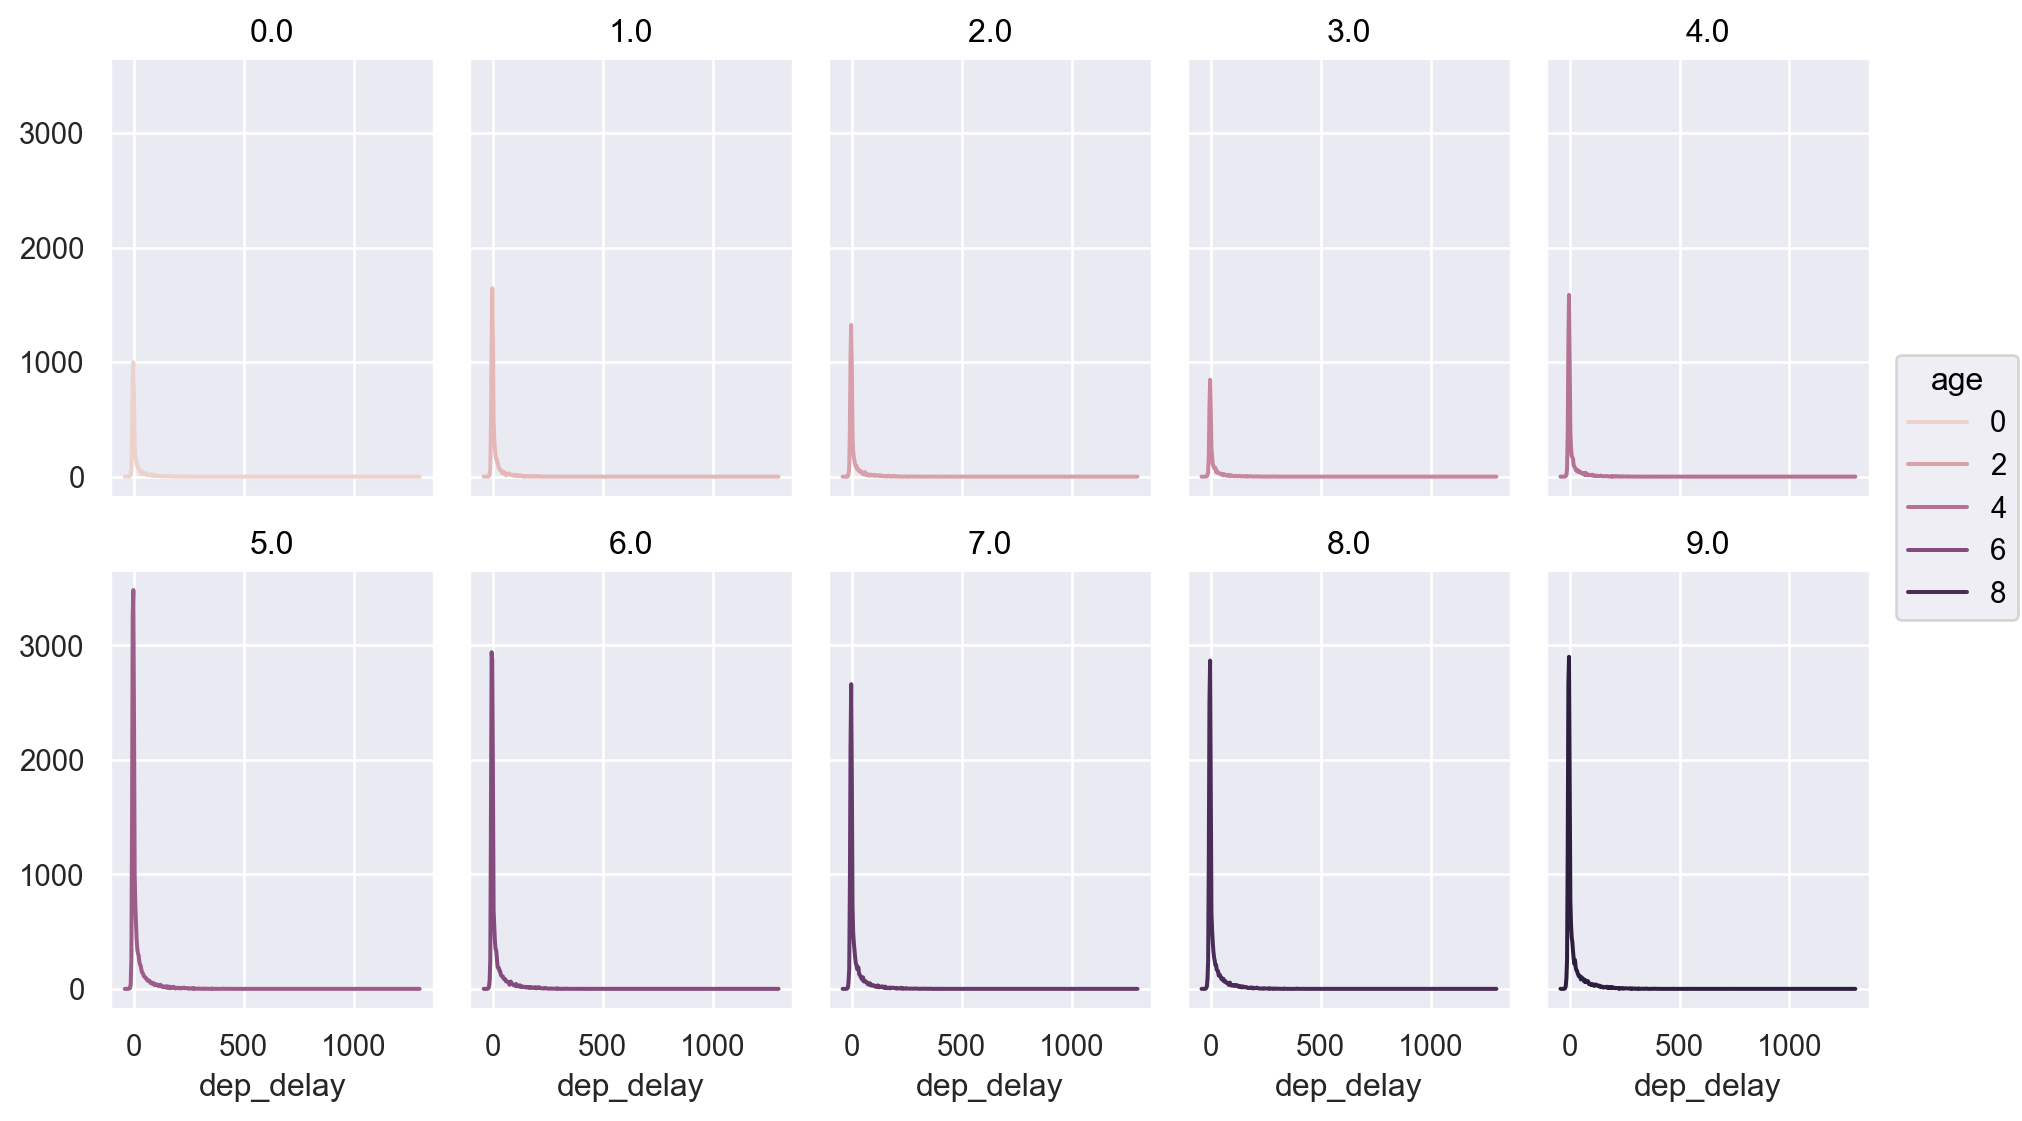

In [43]:
# 출발 지연의 값이 매우 밀집해 있음: 히스토그램으로 확인
(
    so.Plot(plane_age.query('age < 10'), x='dep_delay', color="age")
    .add(so.Line(), so.Hist(binwidth=3))
    .facet("age", wrap=5)
    .layout(size=(10, 6))
)

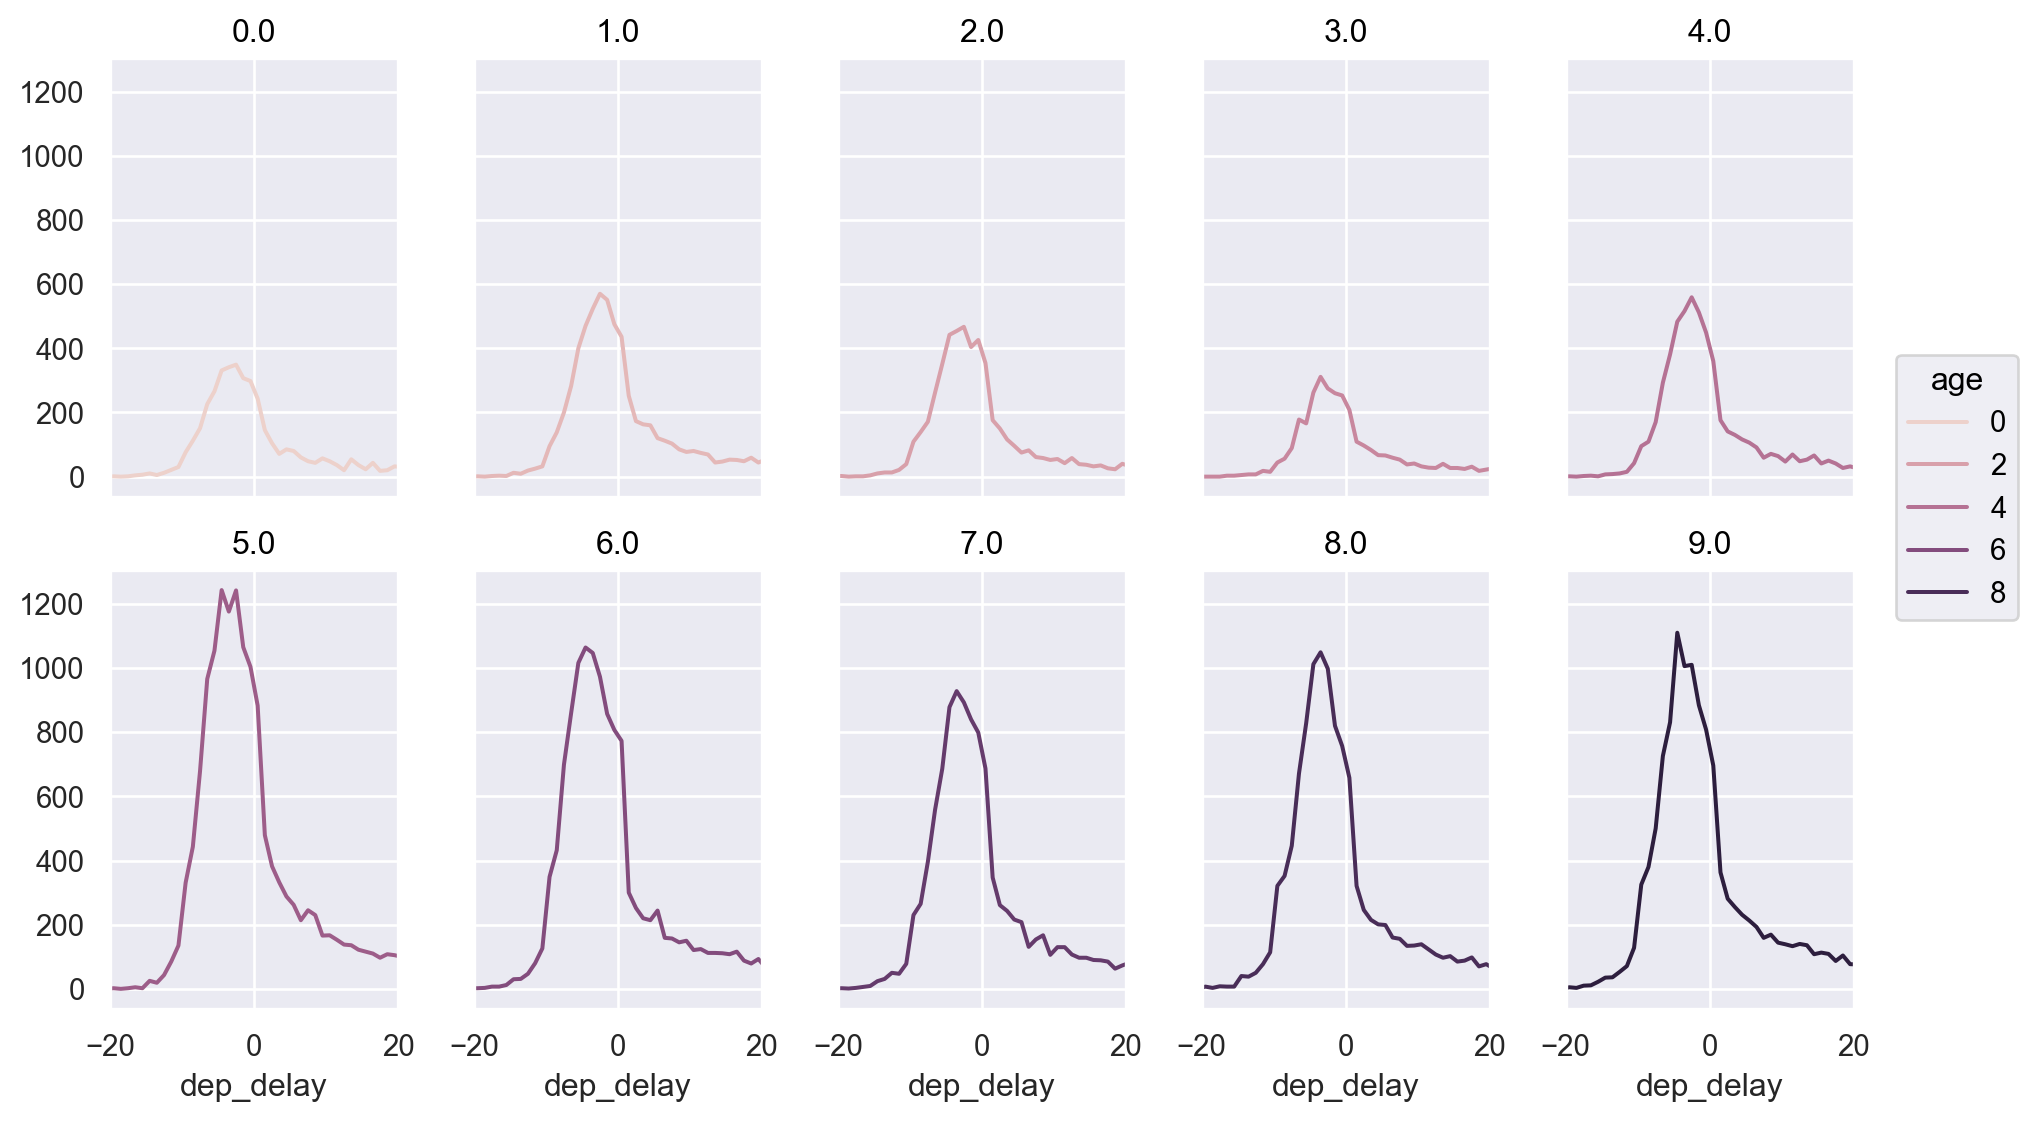

In [44]:
# 출발 지연의 값이 매우 밀집해 있음: 히스토그램으로 확인
(
    so.Plot(plane_age.query('age < 10'), x='dep_delay', color="age")
    .add(so.Line(), so.Hist(binwidth=1))
    .facet("age", wrap=5)
    .layout(size=(10, 6))
    .limit(x=(-20, 20))
)

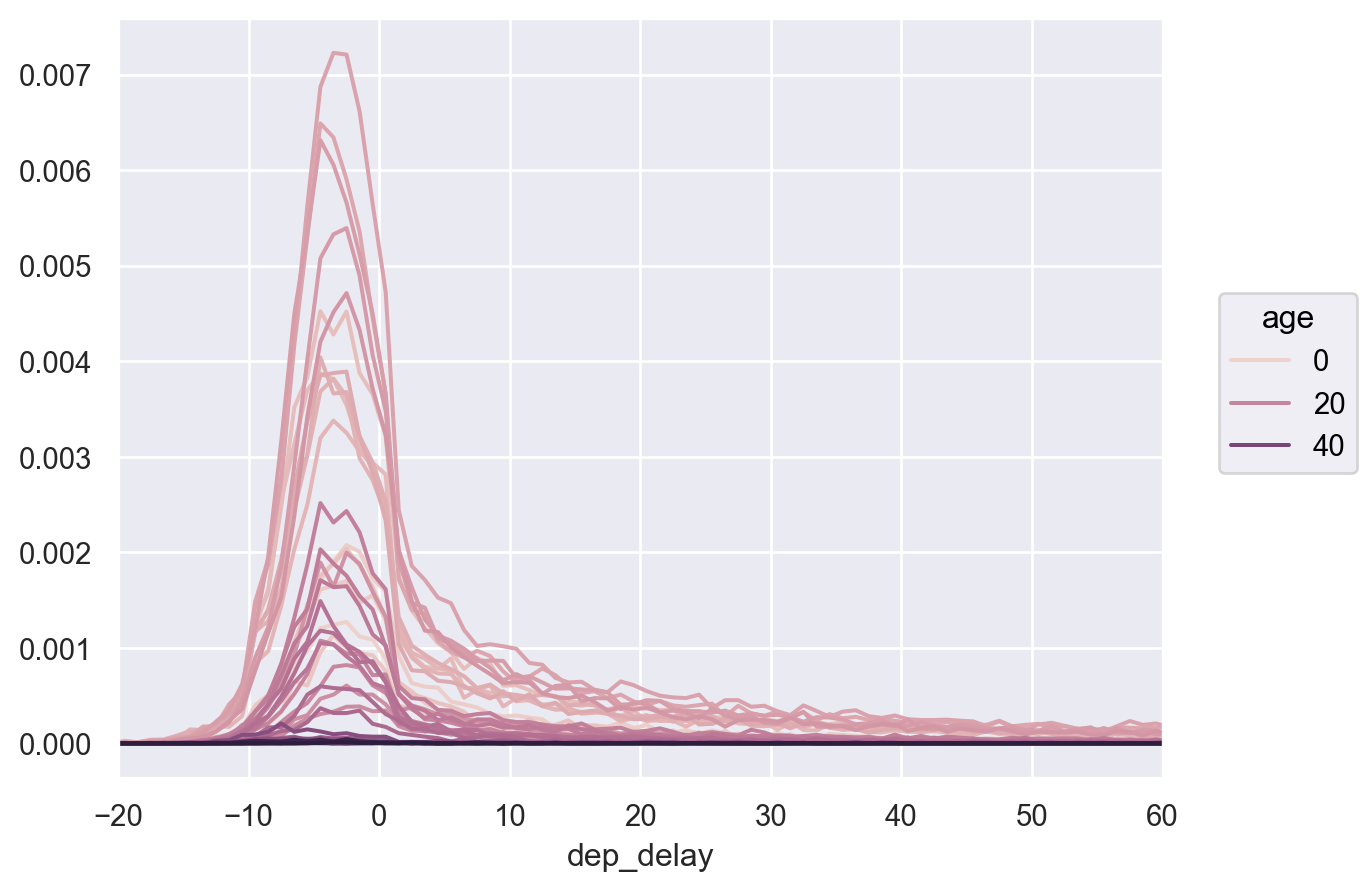

In [45]:
(
    so.Plot(plane_age, x='dep_delay', color="age")
    .add(so.Line(), so.Hist(stat="proportion", binwidth=1))
    .limit(x=(-20, 60))
)

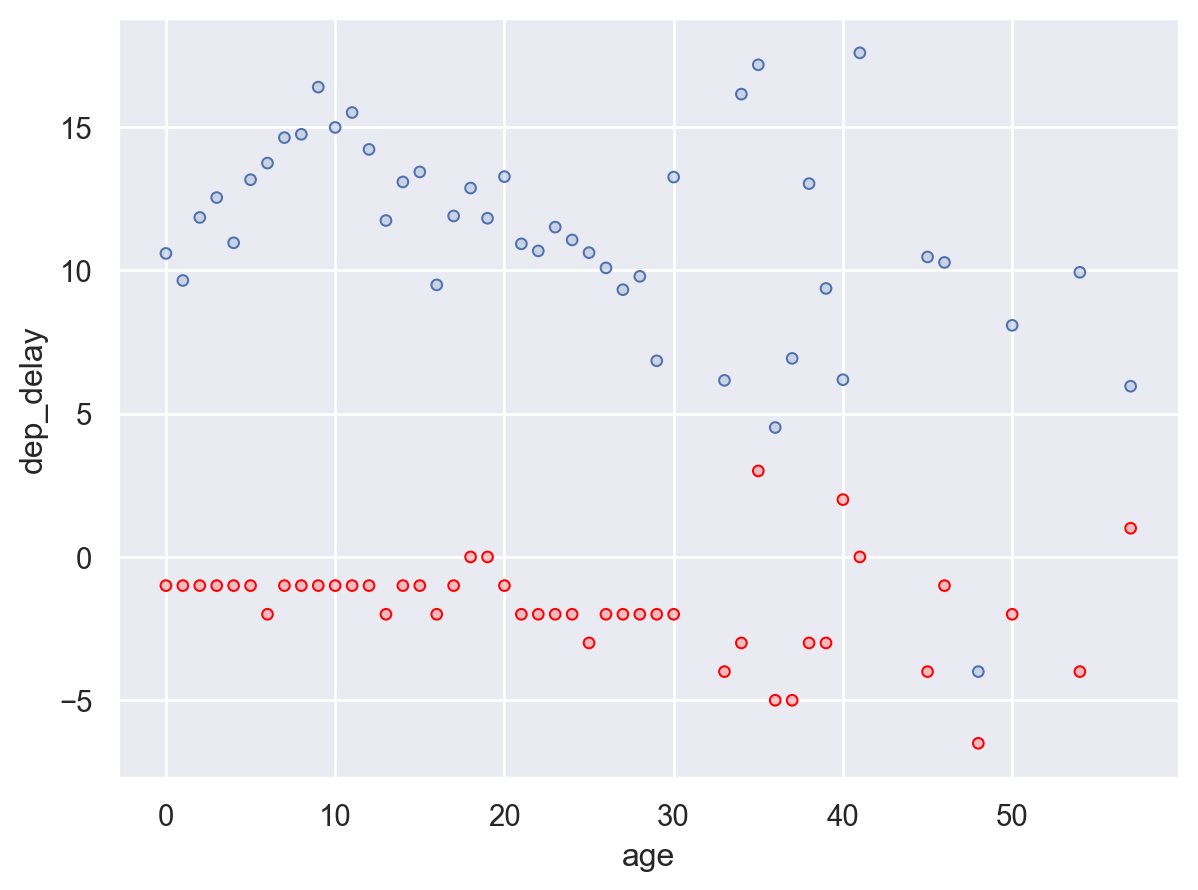

In [46]:
(
    so.Plot(plane_age, x='age', y='dep_delay')
    .add(so.Dots(), so.Agg("mean"))
    .add(so.Dots(color="red"), so.Agg("median"))
)

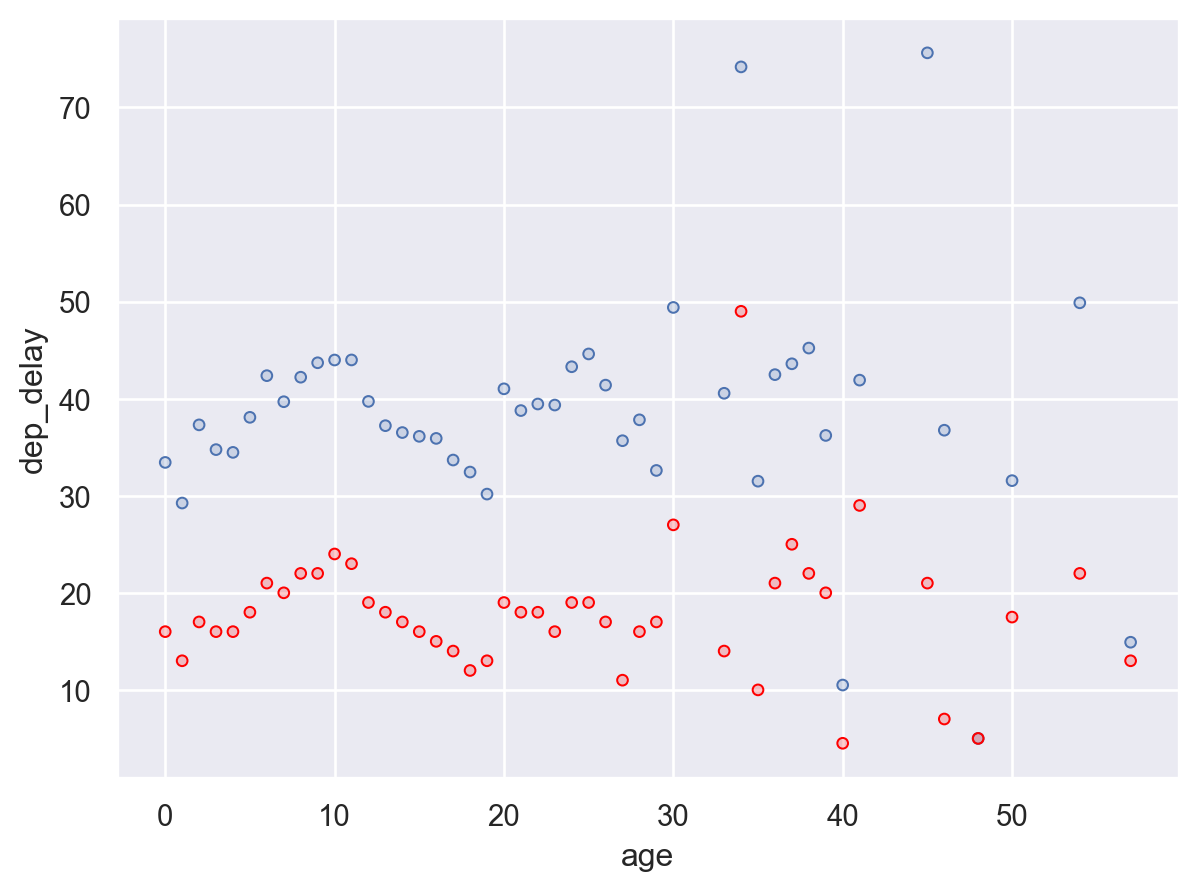

In [47]:
(
    so.Plot(plane_age.query('dep_delay > 0'), x='age', y='dep_delay')
    .add(so.Dots(), so.Agg("mean"))
    .add(so.Dots(color="red"), so.Agg("median"))
)

In [48]:
age_delay = (
    plane_age.query('dep_delay > 0 & dep_delay < 100')
    .groupby("age")["dep_delay"]
    .agg(["mean", "median", "count"])
    .reset_index()
)
age_delay

     age  mean  median  count
0   0.00 22.73   13.00   1686
1   1.00 19.97   11.00   2761
2   2.00 22.54   13.00   2092
..   ...   ...     ...    ...
43 50.00 19.88   14.50     16
44 54.00 26.62   15.00     26
45 57.00 14.91   13.00     11

[46 rows x 4 columns]

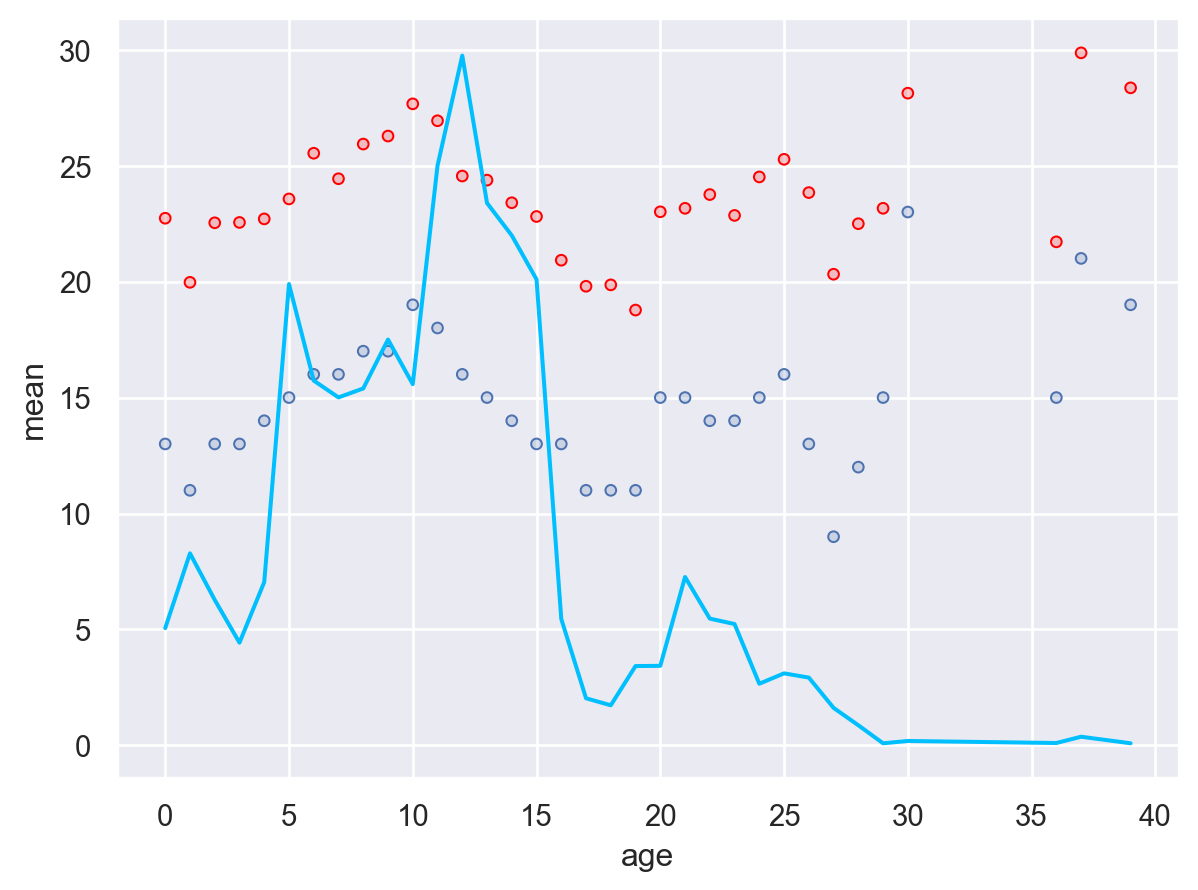

In [49]:
(
    so.Plot(age_delay.query('count > 30'), x='age')
    .add(so.Dots(color="red"), y="mean")
    .add(so.Dots(), y="median")
    .add(so.Line(color="deepskyblue"), y=age_delay["count"]/1000*3)
)

### 3.

In [50]:
# 3. What weather conditions make it more likely to see a delay?

In [51]:
flights_weather = flights.merge(weather)

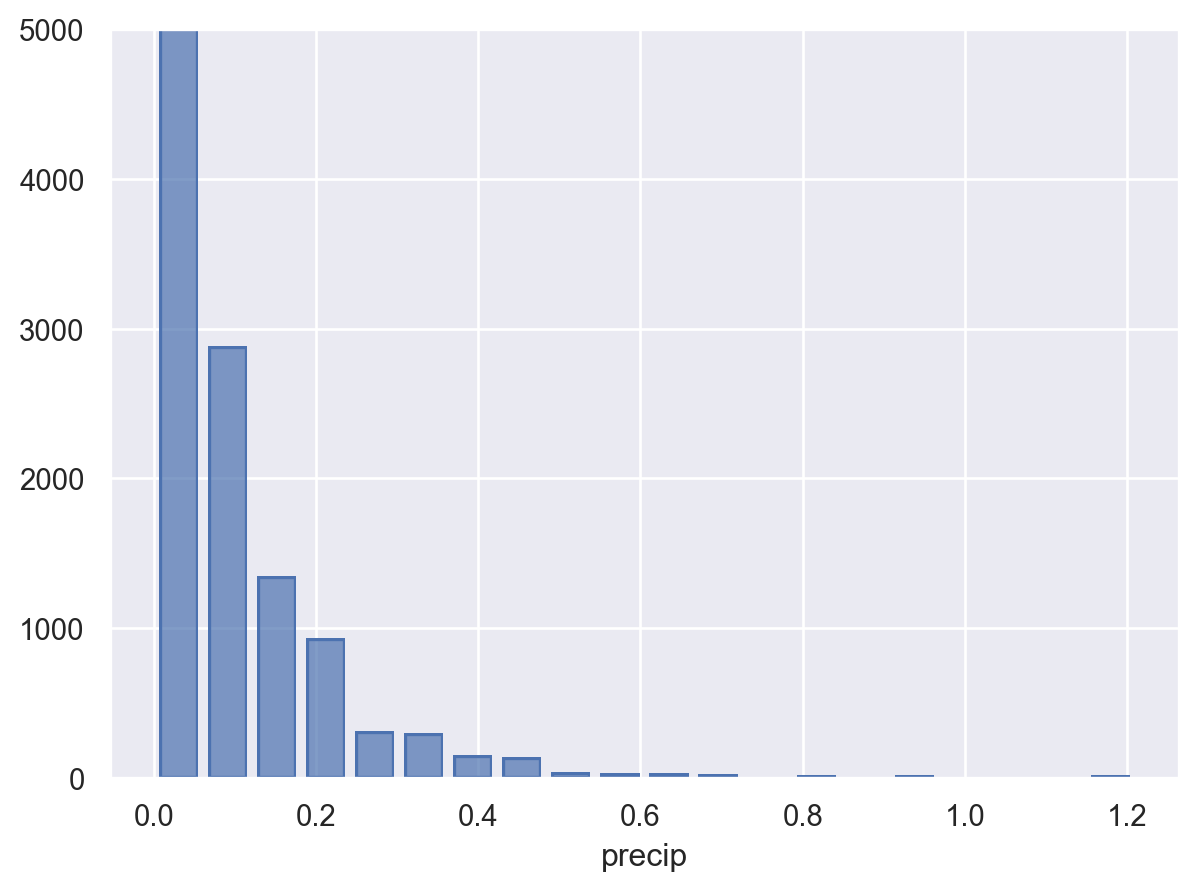

In [52]:
# 강수량 precipitation
(
    so.Plot(flights_weather, x='precip')
    .add(so.Bar(), so.Hist())
    .limit(y=(0, 5000))
)

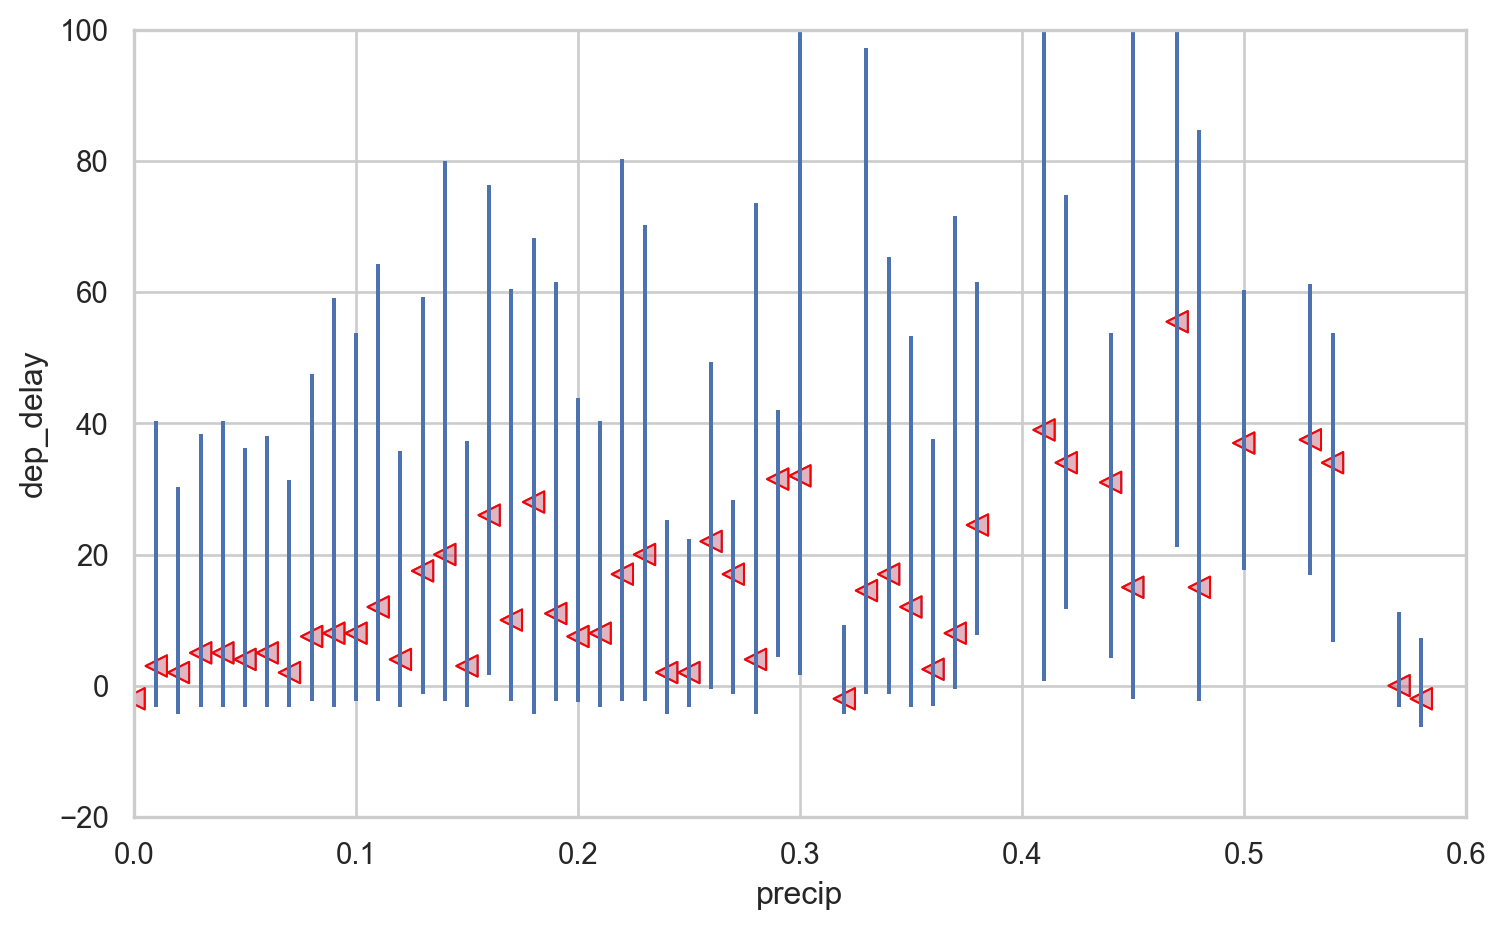

In [53]:
from sbcustom import rangeplot
(
    rangeplot(flights_weather, "precip", "dep_delay")
    .limit(y=(-20, 100), x=(0, 0.6))
    .layout(size=(8, 5))
)

In [25]:
# 강수량 precipitation
precip = flights_weather.groupby("precip")["dep_delay"].agg(["mean", "median"]).reset_index()
precip

    precip   mean  median
0     0.00  11.37   -2.00
1     0.01  29.80    3.00
2     0.02  24.08    2.00
..     ...    ...     ...
52    0.82  94.67   36.00
53    0.94  27.85   19.00
54    1.21 113.11   65.50

[55 rows x 3 columns]

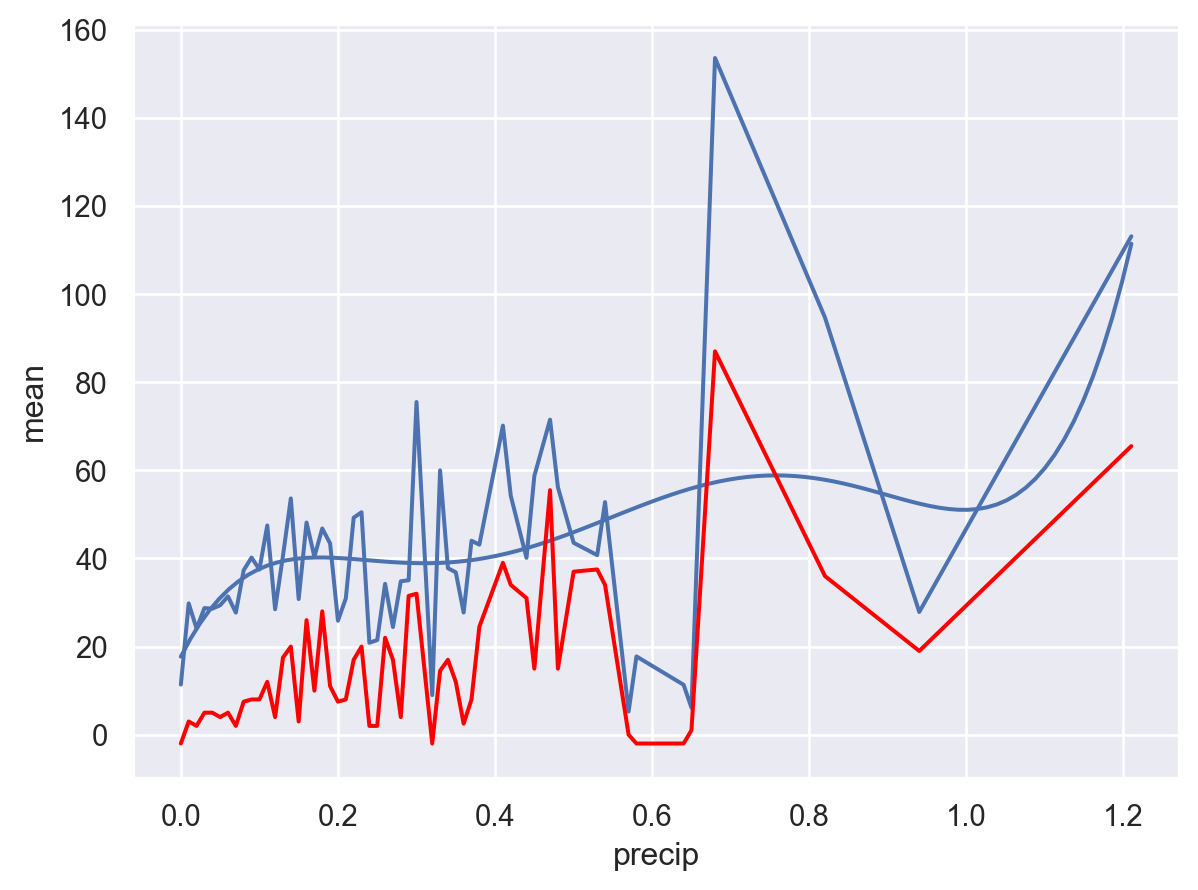

In [26]:
(
    so.Plot(precip, x='precip', y="mean")
    .add(so.Line())
    .add(so.Line(), so.PolyFit(5))
    .add(so.Line(color="red"), y="median")
)

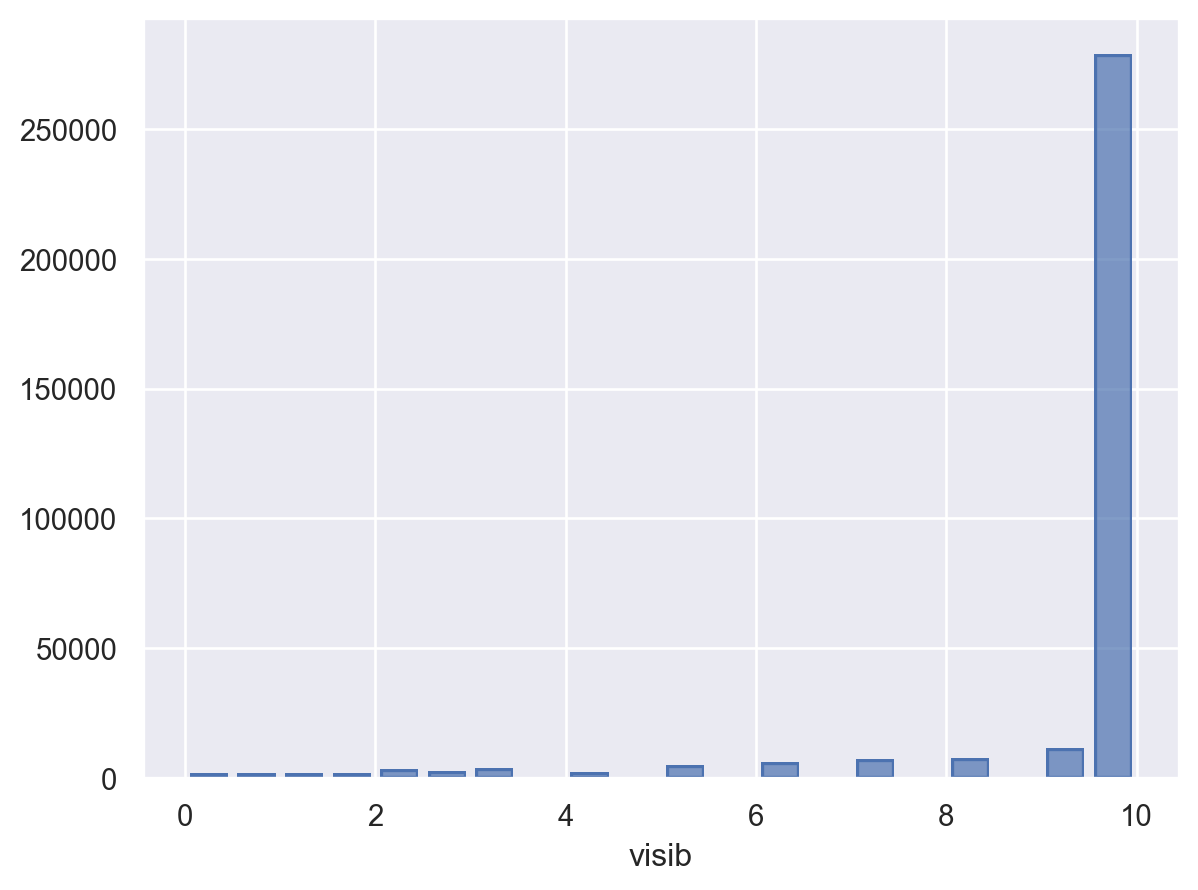

In [27]:
# 시야 visibility
(
    so.Plot(flights_weather, x='visib')
    .add(so.Bar(), so.Hist())
)

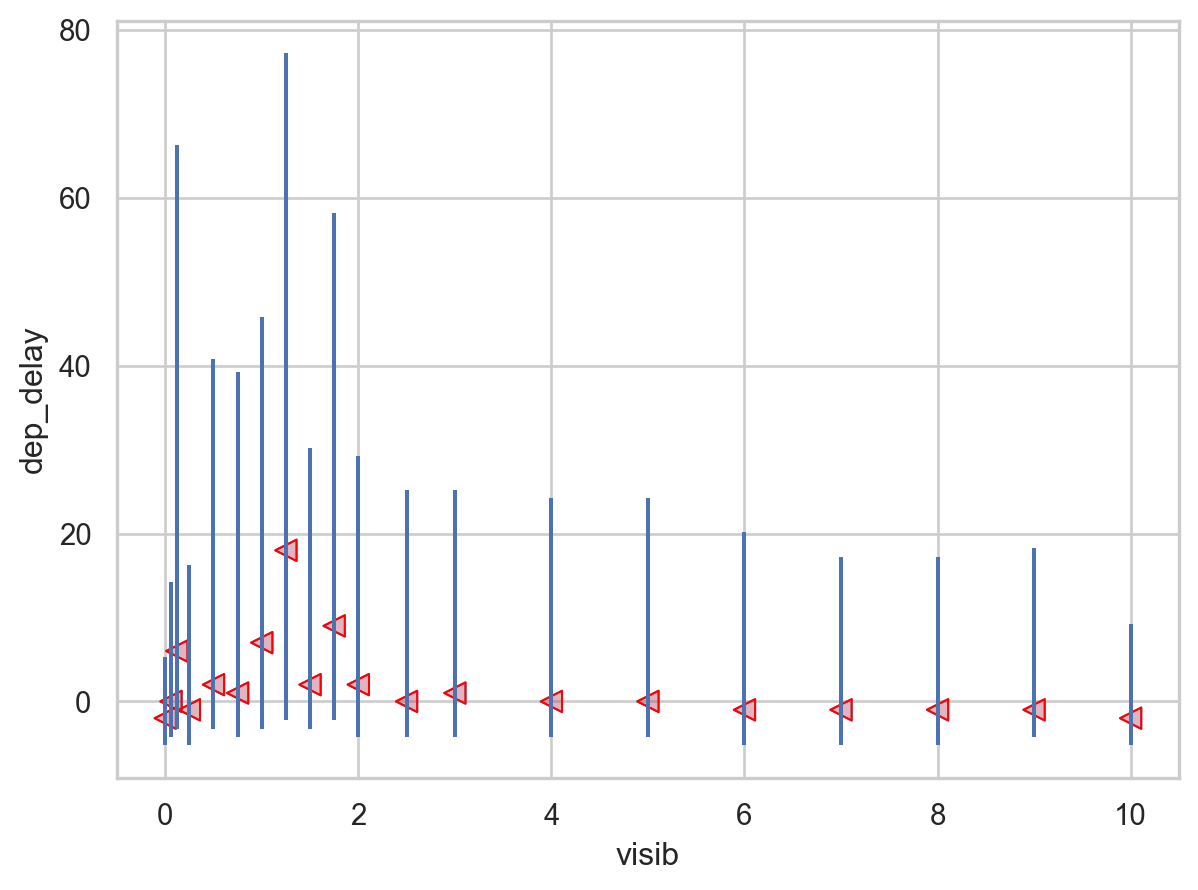

In [28]:
rangeplot(flights_weather, "visib", "dep_delay")

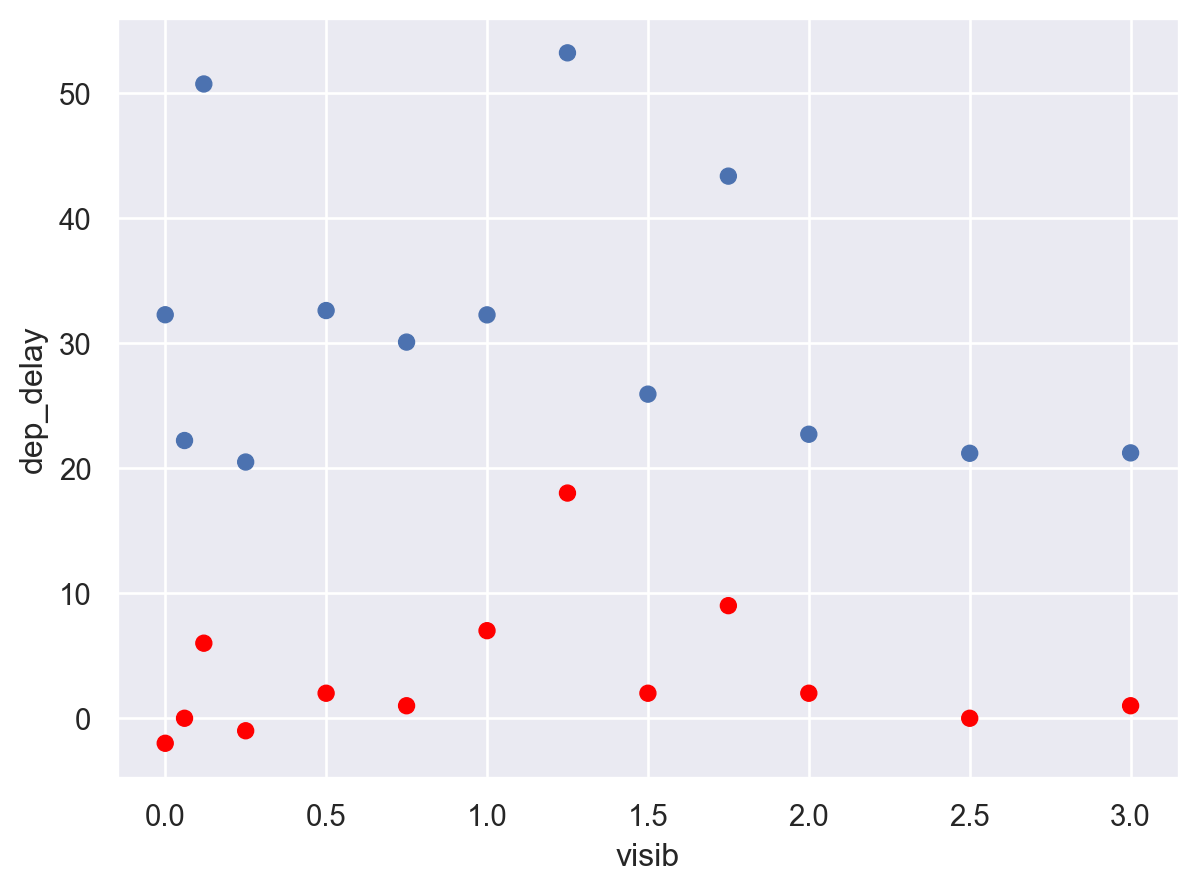

In [29]:
(
    so.Plot(flights_weather.query('visib < 4'), x='visib', y='dep_delay')
    .add(so.Dot(), so.Agg())
    .add(so.Dot(color="red"), so.Agg("median"))
)

### 4.

In [30]:
# 4. flights 테이블에서 하루 평균 도착지연(arr_delay)가 가장 큰 10일에 해당하는 항공편을 선택

In [11]:
delay_top = flights.groupby(["year", "month", "day"])["arr_delay"].mean().sort_values(ascending=False).head(10)
delay_top

year  month  day
2013  3      8     85.86
      6      13    63.75
      7      22    62.76
                    ... 
      12     17    55.87
      8      8     55.48
      12     5     51.67
Name: arr_delay, Length: 10, dtype: float64

In [12]:
flights.merge(delay_top.reset_index(name="daily_delay"), on=["year", "month", "day"]).head(3)  # inner join!

   year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0  2013     12    5     32.00            1930     302.00    228.00   
1  2013     12    5     50.00            2046     244.00    233.00   
2  2013     12    5    457.00             500      -3.00    637.00   

   sched_arr_time  arr_delay carrier  ...  dest air_time distance hour  \
0            2136     292.00      EV  ...   CHS    94.00      628   19   
1            2224     249.00      EV  ...   GSO    80.00      445   20   
2             651     -14.00      US  ...   CLT    81.00      529    5   

   minute  lat_x  lon_x  lat_y  lon_y  daily_delay  
0      30  40.69 -74.17  40.69 -74.17        51.67  
1      46  40.69 -74.17  40.69 -74.17        51.67  
2       0  40.69 -74.17  40.69 -74.17        51.67  

[3 rows x 23 columns]

### 5.

In [13]:
# 5. flights 테이블의 도착지(dest)에 대한 공항정보가 airports 테이블에 없는 그러한 도착지(dest)를 구하면?

idx = ~flights["dest"].isin(airports["faa"])  # boolian index
flights[idx]["dest"].unique()

array(['SJU', 'STT', 'BQN', 'PSE'], dtype=object)

### 6.

In [14]:
# 6. Filter flights (항공편) in flights to only show flights with planes that have flown at least 100 flights.

n_planes = (
    flights.groupby("tailnum")["dep_delay"].count()  # 취소된 항공편을 제외하기 위함. size()는 취소된 항공편도 포함
    .reset_index(name="n")
    .query('n >= 100')
)
n_planes

     tailnum    n
1     N0EGMQ  354
2     N10156  146
6     N10575  272
...      ...  ...
4003  N979DL  125
4036  N996DL  101
4042  N9EAMQ  238

[1210 rows x 2 columns]

In [15]:
flights.merge(n_planes).head(3)  # inner join!

   year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0  2013      1    1    517.00             515       2.00    830.00   
1  2013      1    8   1435.00            1440      -5.00   1717.00   
2  2013      1    9    717.00             700      17.00    812.00   

   sched_arr_time  arr_delay carrier  ...  dest air_time distance hour  \
0             819      11.00      UA  ...   IAH   227.00     1400    5   
1            1746     -29.00      UA  ...   MIA   150.00     1085   14   
2             815      -3.00      UA  ...   BOS    39.00      200    7   

   minute  lat_x  lon_x  lat_y  lon_y    n  
0      15  40.69 -74.17  40.69 -74.17  111  
1      40  40.69 -74.17  40.69 -74.17  111  
2       0  40.69 -74.17  40.69 -74.17  111  

[3 rows x 23 columns]

### 7.

In [36]:
# 7. Find the 48 hours (over the course of the whole year) that have the worst (departure) delays. Cross-reference it with the weather data. Can you see any patterns?

In [16]:
worst_hours = (
    flights.groupby(["origin", "year", "month", "day", "hour"])["dep_delay"]
    .mean()
    .nlargest(48)
    .reset_index(name="ave_delay")
)
worst_hours

   origin  year  month  day  hour  ave_delay
0     LGA  2013      7   28    21     279.67
1     EWR  2013      2    9    10     269.00
2     EWR  2013      2    9     9     266.00
..    ...   ...    ...  ...   ...        ...
45    LGA  2013      3    8    15     155.81
46    EWR  2013      7   10    19     155.31
47    LGA  2013      3    8    11     155.20

[48 rows x 6 columns]

In [17]:
# Merge with weather
weather_most_delayed = weather.merge(worst_hours, how="left")  # on=["origin", "year", "month", "day", "hour"]

weather_most_delayed.head(3)

  origin  year  month  day  hour  temp  dewp  humid  wind_dir  wind_speed  \
0    EWR  2013      1    1     1 39.02 26.06  59.37    270.00       10.36   
1    EWR  2013      1    1     2 39.02 26.96  61.63    250.00        8.06   
2    EWR  2013      1    1     3 39.02 28.04  64.43    240.00       11.51   

   wind_gust  precip  pressure  visib            time_hour  ave_delay  
0        NaN    0.00   1012.00  10.00  2013-01-01 01:00:00        NaN  
1        NaN    0.00   1012.30  10.00  2013-01-01 02:00:00        NaN  
2        NaN    0.00   1012.50  10.00  2013-01-01 03:00:00        NaN  

In [18]:
# Worst에 포함되는지를 표시하는 컬럼 추가 (tag)
weather_most_delayed["tag"] = np.where(weather_most_delayed["ave_delay"].isna(), "others", "worst")

weather_most_delayed.head(3)

  origin  year  month  day  hour  temp  dewp  humid  wind_dir  wind_speed  \
0    EWR  2013      1    1     1 39.02 26.06  59.37    270.00       10.36   
1    EWR  2013      1    1     2 39.02 26.96  61.63    250.00        8.06   
2    EWR  2013      1    1     3 39.02 28.04  64.43    240.00       11.51   

   wind_gust  precip  pressure  visib            time_hour  ave_delay     tag  
0        NaN    0.00   1012.00  10.00  2013-01-01 01:00:00        NaN  others  
1        NaN    0.00   1012.30  10.00  2013-01-01 02:00:00        NaN  others  
2        NaN    0.00   1012.50  10.00  2013-01-01 03:00:00        NaN  others  

In [19]:
# Normalize the weather conditions
weather_most_delayed_z = weather_most_delayed.copy()
weather_most_delayed_z.loc[:, "temp":"visib"] = weather_most_delayed_z.loc[
    :, "temp":"visib"
].apply(lambda x: (x - x.mean()) / x.std())  # 컬럼별로 정규화

weather_most_delayed_z.head(3)

  origin  year  month  day  hour  temp  dewp  humid  wind_dir  wind_speed  \
0    EWR  2013      1    1     1 -0.91 -0.79  -0.16      0.65       -0.02   
1    EWR  2013      1    1     2 -0.91 -0.75  -0.05      0.47       -0.29   
2    EWR  2013      1    1     3 -0.91 -0.69   0.10      0.37        0.12   

   wind_gust  precip  pressure  visib            time_hour  ave_delay     tag  
0        NaN   -0.15     -0.79   0.36  2013-01-01 01:00:00        NaN  others  
1        NaN   -0.15     -0.75   0.36  2013-01-01 02:00:00        NaN  others  
2        NaN   -0.15     -0.73   0.36  2013-01-01 03:00:00        NaN  others  

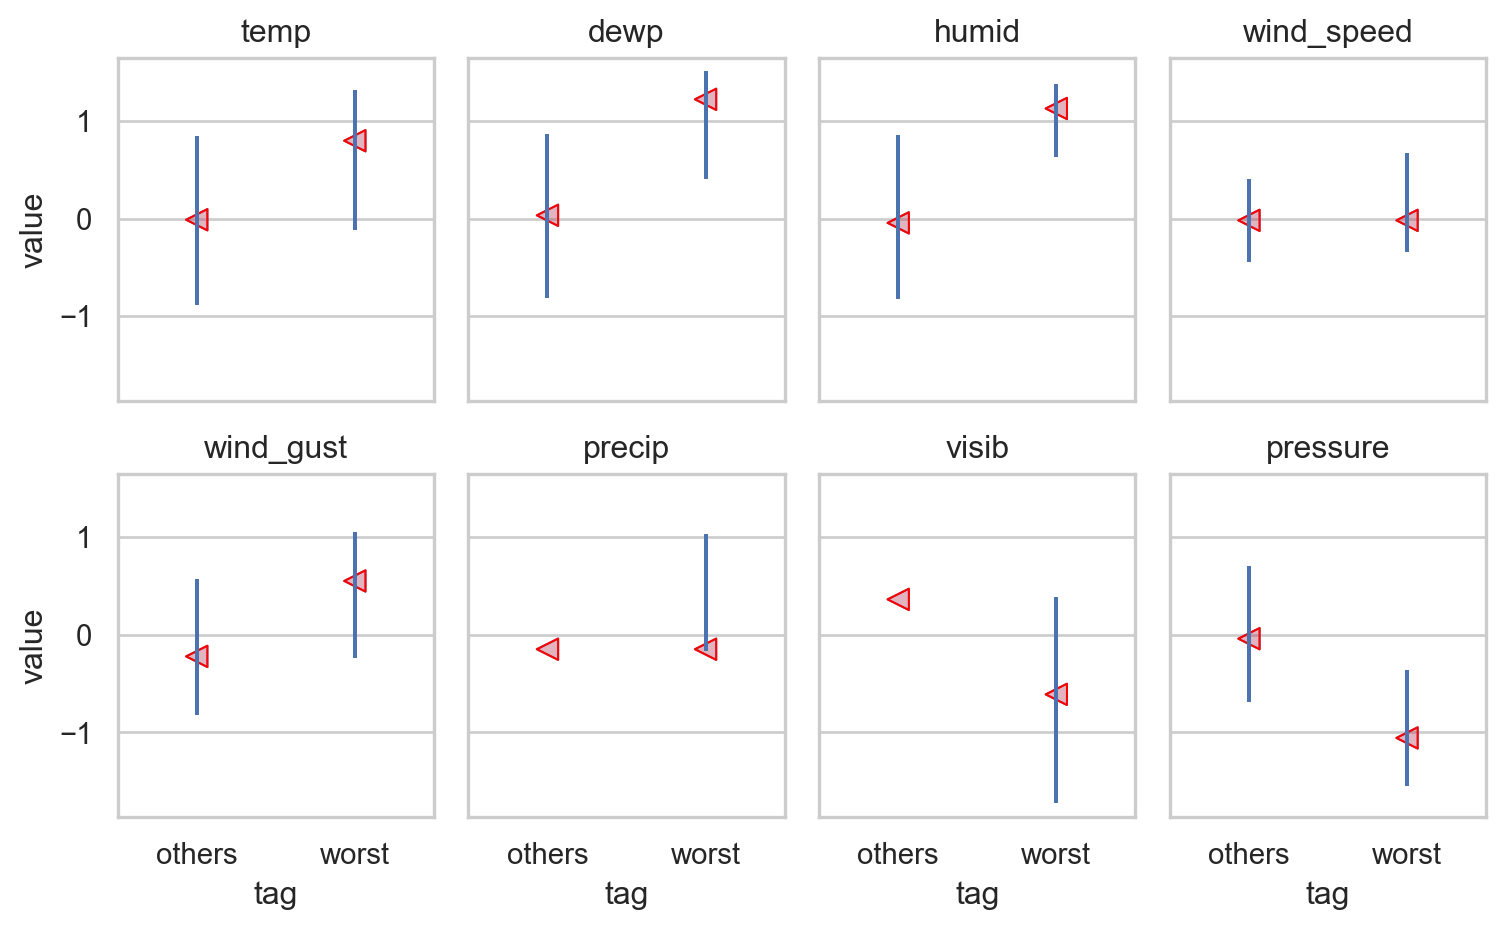

In [20]:
# 여러 기상 정보에 대해 long form으로 변환
weather_most_delayed_long = weather_most_delayed_z.melt(
    id_vars=["origin", "year", "month", "day", "hour", "tag"],
    value_vars=[
        "temp",
        "dewp",
        "humid",
        "wind_speed",
        "wind_gust",
        "precip",
        "visib",
        "pressure",
    ],
    var_name="weather",
)

from sbcustom import boxplot, rangeplot
(
    rangeplot(weather_most_delayed_long, x='tag', y='value')
    .facet("weather", wrap=4)
    .layout(size=(8, 5))
)

In [21]:
# 참고 anti-join: worst_hours와 키가 매치되지 않는 행만 선택
(
    weather
    .merge(worst_hours, indicator=True, how="left")
    .query('_merge == "left_only"')
).head(3)

  origin  year  month  day  hour  temp  dewp  humid  wind_dir  wind_speed  \
0    EWR  2013      1    1     1 39.02 26.06  59.37    270.00       10.36   
1    EWR  2013      1    1     2 39.02 26.96  61.63    250.00        8.06   
2    EWR  2013      1    1     3 39.02 28.04  64.43    240.00       11.51   

   wind_gust  precip  pressure  visib            time_hour  ave_delay  \
0        NaN    0.00   1012.00  10.00  2013-01-01 01:00:00        NaN   
1        NaN    0.00   1012.30  10.00  2013-01-01 02:00:00        NaN   
2        NaN    0.00   1012.50  10.00  2013-01-01 03:00:00        NaN   

      _merge  
0  left_only  
1  left_only  
2  left_only  

### 8.

In [ ]:
# 8. You might expect that there’s an implicit relationship between plane and airline, because each plane is flown by a single airline. Confirm or reject this hypothesis using the tools you’ve learned above.

In [24]:
# 즉, 각 항공기는 특정 항공사에서만 운행되는가의 질문임. 2개 이상의 항공사에서 운항되는 항공기가 있는지 확인해 볼 것

planes_share = (
    flights.groupby("tailnum")["carrier"].nunique()
    .reset_index(name="n")
    .query("n > 1")
)
planes_share

     tailnum  n
195   N146PQ  2
224   N153PQ  2
342   N176PQ  2
...      ... ..
4021  N989AT  2
4023  N990AT  2
4031  N994AT  2

[17 rows x 2 columns]

In [28]:
# 그리고, 2개 이상의 항공사에서 운항되는 항공기들만 포함하고, 그 항공사들의 full name을 함께 포함하는 테이블을 만들어 볼 것

flights.merge(planes_share).merge(airlines).head(3)

   year  month  day  dep_time  sched_dep_time  dep_delay  arr_time  \
0  2013      1   11   1244.00            1250      -6.00   1459.00   
1  2013      1   11   1821.00            1830      -9.00   2014.00   
2  2013      1   15    612.00             615      -3.00    927.00   

   sched_arr_time  arr_delay carrier  ...  air_time distance hour minute  \
0            1449      10.00      9E  ...     92.00      488   12     50   
1            2044     -30.00      9E  ...     79.00      488   18     30   
2             855      32.00      9E  ...    134.00      760    6     15   

   lat_x  lon_x  lat_y  lon_y  n               name  
0  40.69 -74.17  40.69 -74.17  2  Endeavor Air Inc.  
1  40.69 -74.17  40.69 -74.17  2  Endeavor Air Inc.  
2  40.64 -73.78  40.64 -73.78  2  Endeavor Air Inc.  

[3 rows x 24 columns]